# **0.0 DATA PROCESSING**

In [1]:
!git clone https://github.com/edwinkmusaasizi/Machine-Learning.git

Cloning into 'Machine-Learning'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 164 (delta 93), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (164/164), 968.24 KiB | 6.33 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [2]:
%cd Machine-Learning
%cd data
%cd interim
!ls

/content/Machine-Learning
/content/Machine-Learning/data
/content/Machine-Learning/data/interim
cleaned_mental_health_data.csv


0.1 Data Processing

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load data
df = pd.read_csv("cleaned_mental_health_data.csv")

# Define adherence labels based on questionnaire responses
non_adherence_columns = [
    "Do you ever forget to take your medication?",
    "Are you careless at times about taking your medication?",
    "When you feel better, do you sometimes stop taking your medication?",
    "Sometimes if you feel worse when you take the medication, do you stop taking it?",
    "I take my medication only when I am sick"
]

df["adherence"] = np.where(df[non_adherence_columns].eq("Yes").any(axis=1), 0, 1)

# Drop redundant columns
df = df.drop(columns=non_adherence_columns + ["If you have any further comments about medication or this questionnaire, please write them below"])

# Identify all categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns to encode:", categorical_cols)

# Encode all categorical features
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Split features and labels
X = df.drop(columns="adherence").values
y = df["adherence"].values

# Split data into train, validation, test (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE to only the training set
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
from collections import Counter
print("New class distribution:", Counter(y_train_resampled))

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Categorical columns to encode: Index(['sex', 'Religion', 'marital status', 'education status', 'residence',
       'substance use', 'comorbidity',
       'It is unnatural for my mind and body to be controlled by medication?',
       'My thoughts are clearer on medication',
       'By staying on medication, I can prevent getting sick',
       'I feel weird, like a ‘zombie’ on medication',
       'Medication makes me feel tired and sluggish',
       'Some of your symptoms are made by your mind.', 'You are mentally well',
       'You do not need medication', 'Your stay in the hospital is necessary',
       'The doctor is right in prescribing medication for you.',
       'You do not need to be seen by a doctor or psychiatrist',
       'If someone said you have a nervous or mental illness, they would be right',
       'None of the unusual things you are experiencing are due to an illness.',
       '. Loss of energy or drive', 'Feeling unmotivated or numb',
       'Daytime sedation or drowsi

In [4]:
# Check class distribution in the training set
class_distribution = np.bincount(y_train)
print("Class Distribution in Training Set:")
print(f"Class 0 (Non-Adherent): {class_distribution[0]}")
print(f"Class 1 (Adherent): {class_distribution[1]}")

Class Distribution in Training Set:
Class 0 (Non-Adherent): 55
Class 1 (Adherent): 26


Implement class weight

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Example model (Assuming a simple neural network)
class AdherenceModel(nn.Module):
    def __init__(self, input_size):
        super(AdherenceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)  # Output has 2 classes (0 and 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # No softmax needed for CrossEntropyLoss
        return x

# Initialize model
input_size = X_train.shape[1]  # Number of features
model = AdherenceModel(input_size)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
for epoch in range(10):  # Adjust epochs as needed
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        batch_y = batch_y.long()  # Convert to long for CrossEntropyLoss
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")



Epoch 1, Loss: 0.678307056427002
Epoch 2, Loss: 0.6478133797645569
Epoch 3, Loss: 0.6054360866546631
Epoch 4, Loss: 0.5940439105033875
Epoch 5, Loss: 0.5443367958068848
Epoch 6, Loss: 0.5207661986351013
Epoch 7, Loss: 0.5618281960487366
Epoch 8, Loss: 0.5907427668571472
Epoch 9, Loss: 0.5104557275772095
Epoch 10, Loss: 0.5371582508087158


# MODEL IMPLEMANTION

## Implement Logisitic Regretion

1 Import Libraries

In [12]:
from sklearn.linear_model import LogisticRegression
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assuming data preprocessing has been done and the data is available in these variables
# X_train, X_val, X_test, y_train, y_val, y_test
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


2. Training

In [13]:
# Initialize the Logistic Regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Record the start time for training
start_time = time.time()

# Train the model
logreg_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time


3. Evaluation

In [14]:
import pandas as pd

# Get predicted probabilities
y_prob_logreg = logreg_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_logreg = (y_prob_logreg >= 0.5).astype(int)

# Calculate evaluation metrics
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)
logreg_auc = roc_auc_score(y_test, y_prob_logreg)

# Store results in a dictionary for comparison
model_results = {
    "Model": ["Logistic Regression"],
    "Precision": [logreg_precision],
    "Recall": [logreg_recall],
    "F1-Score": [logreg_f1],
    "AUC": [logreg_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Display results
print(results_df)


                 Model  Precision    Recall  F1-Score       AUC  \
0  Logistic Regression       0.25  0.166667       0.2  0.347222   

   Training Time (s)  
0           0.030355  


## Implementing Support Vector Machine

In [15]:
from sklearn.svm import SVC
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assuming data preprocessing has been done and the data is available in these variables
# X_train, X_val, X_test, y_train, y_val, y_test
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Initialize the SVM model with a radial basis function kernel
svm_model = SVC(probability=True, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time


Evaluation

In [16]:
# Get predicted probabilities
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_svm = (y_prob_svm >= 0.5).astype(int)

# Calculate evaluation metrics
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_auc = roc_auc_score(y_test, y_prob_svm)

# Store results in a dictionary for comparison
svm_results = {
    "Model": ["Support Vector Machine (SVM)"],
    "Precision": [svm_precision],
    "Recall": [svm_recall],
    "F1-Score": [svm_f1],
    "AUC": [svm_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
svm_results_df = pd.DataFrame(svm_results)

# Append to the existing results DataFrame
results_df = pd.concat([results_df, svm_results_df], ignore_index=True)

# Display updated results
print(results_df)


                          Model  Precision    Recall  F1-Score       AUC  \
0           Logistic Regression       0.25  0.166667       0.2  0.347222   
1  Support Vector Machine (SVM)       0.00  0.000000       0.0  0.416667   

   Training Time (s)  
0           0.030355  
1           0.003695  


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Implementing Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assuming data preprocessing has been done and the data is available in these variables
# X_train, X_val, X_test, y_train, y_val, y_test
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#TRAINING

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time




Evaluation

In [18]:
# Get predicted probabilities
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

# Calculate evaluation metrics
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)

# Store results in a dictionary for comparison
rf_results = {
    "Model": ["Random Forest"],
    "Precision": [rf_precision],
    "Recall": [rf_recall],
    "F1-Score": [rf_f1],
    "AUC": [rf_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
rf_results_df = pd.DataFrame(rf_results)

# Append to the existing results DataFrame
results_df = pd.concat([results_df, rf_results_df], ignore_index=True)

# Display updated results
print(results_df)


                          Model  Precision    Recall  F1-Score       AUC  \
0           Logistic Regression       0.25  0.166667  0.200000  0.347222   
1  Support Vector Machine (SVM)       0.00  0.000000  0.000000  0.416667   
2                 Random Forest       1.00  0.166667  0.285714  0.465278   

   Training Time (s)  
0           0.030355  
1           0.003695  
2           0.125010  


## Implementing a K-Nearest Neighbor

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Initialize KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Record the start time for training
start_time = time.time()

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_scaled)




In [20]:
# Get predicted probabilities
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_knn = (y_prob_knn >= 0.5).astype(int)

# Calculate evaluation metrics
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)
knn_auc = roc_auc_score(y_test, y_prob_knn)

# Store results in a dictionary for comparison
knn_results = {
    "Model": ["K-Nearest Neighbors (KNN)"],
    "Precision": [knn_precision],
    "Recall": [knn_recall],
    "F1-Score": [knn_f1],
    "AUC": [knn_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
knn_results_df = pd.DataFrame(knn_results)

# Append to the existing results DataFrame
results_df = pd.concat([results_df, knn_results_df], ignore_index=True)

# Display updated results
print(results_df)


                          Model  Precision    Recall  F1-Score       AUC  \
0           Logistic Regression   0.250000  0.166667  0.200000  0.347222   
1  Support Vector Machine (SVM)   0.000000  0.000000  0.000000  0.416667   
2                 Random Forest   1.000000  0.166667  0.285714  0.465278   
3     K-Nearest Neighbors (KNN)   0.666667  0.333333  0.444444  0.645833   

   Training Time (s)  
0           0.030355  
1           0.003695  
2           0.125010  
3           0.000897  


Implementing Gradient Boost machine

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time

# Initialize Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
gbm_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()
training_time = end_time - start_time

# Predict on the validation and test sets
y_val_pred = gbm_model.predict(X_val_scaled)
y_test_pred = gbm_model.predict(X_test_scaled)

# Get predicted probabilities
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_knn = (y_prob_knn >= 0.5).astype(int)

# Calculate evaluation metrics
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)
knn_auc = roc_auc_score(y_test, y_prob_knn)

# Store results in a dictionary for comparison
knn_results = {
    "Model": ["K-Nearest Neighbors (KNN)"],
    "Precision": [knn_precision],
    "Recall": [knn_recall],
    "F1-Score": [knn_f1],
    "AUC": [knn_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
knn_results_df = pd.DataFrame(knn_results)

# Append to the existing results DataFrame
results_df = pd.concat([results_df, knn_results_df], ignore_index=True)

# Display updated results
print(results_df)


                          Model  Precision    Recall  F1-Score       AUC  \
0           Logistic Regression   0.250000  0.166667  0.200000  0.347222   
1  Support Vector Machine (SVM)   0.000000  0.000000  0.000000  0.416667   
2                 Random Forest   1.000000  0.166667  0.285714  0.465278   
3     K-Nearest Neighbors (KNN)   0.666667  0.333333  0.444444  0.645833   
4     K-Nearest Neighbors (KNN)   0.666667  0.333333  0.444444  0.645833   

   Training Time (s)  
0           0.030355  
1           0.003695  
2           0.125010  
3           0.000897  
4           0.122181  


## Implementing XGBoost

In [22]:
!pip install xgboost


In [23]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time

# Initialize XGBoost Classifier
xgboost_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
xgboost_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()
training_time = end_time - start_time

# Predict on the validation and test sets
y_val_pred = xgboost_model.predict(X_val_scaled)
y_test_pred = xgboost_model.predict(X_test_scaled)

# Get predicted probabilities
y_prob_xgb = xgboost_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

# Calculate evaluation metrics
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)

# Store results in a dictionary for comparison
xgb_results = {
    "Model": ["XGBoost"],
    "Precision": [xgb_precision],
    "Recall": [xgb_recall],
    "F1-Score": [xgb_f1],
    "AUC": [xgb_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
xgb_results_df = pd.DataFrame(xgb_results)

# Append to the existing results DataFrame
results_df = pd.concat([results_df, xgb_results_df], ignore_index=True)

# Display updated results
print(results_df)



                          Model  Precision    Recall  F1-Score       AUC  \
0           Logistic Regression   0.250000  0.166667  0.200000  0.347222   
1  Support Vector Machine (SVM)   0.000000  0.000000  0.000000  0.416667   
2                 Random Forest   1.000000  0.166667  0.285714  0.465278   
3     K-Nearest Neighbors (KNN)   0.666667  0.333333  0.444444  0.645833   
4     K-Nearest Neighbors (KNN)   0.666667  0.333333  0.444444  0.645833   
5                       XGBoost   0.200000  0.166667  0.181818  0.375000   

   Training Time (s)  
0           0.030355  
1           0.003695  
2           0.125010  
3           0.000897  
4           0.122181  
5           0.088999  


## Implementing LightGBM

In [24]:
!pip install lightgbm


In [25]:
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time

# Initialize LightGBM Classifier
lgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
lgbm_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()
training_time = end_time - start_time

# Predict on the validation and test sets
y_val_pred = lgbm_model.predict(X_val_scaled)
y_test_pred = lgbm_model.predict(X_test_scaled)

# Get predicted probabilities
y_prob_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_lgbm = (y_prob_lgbm >= 0.5).astype(int)

# Calculate evaluation metrics
lgbm_precision = precision_score(y_test, y_pred_lgbm)
lgbm_recall = recall_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm)
lgbm_auc = roc_auc_score(y_test, y_prob_lgbm)

# Store results in a dictionary for comparison
lgbm_results = {
    "Model": ["LightGBM"],
    "Precision": [lgbm_precision],
    "Recall": [lgbm_recall],
    "F1-Score": [lgbm_f1],
    "AUC": [lgbm_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
lgbm_results_df = pd.DataFrame(lgbm_results)

# Append to the existing results DataFrame
results_df = pd.concat([results_df, lgbm_results_df], ignore_index=True)

# Display updated results
print(results_df)


[LightGBM] [Info] Number of positive: 26, number of negative: 55
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320988 -> initscore=-0.749237
[LightGBM] [Info] Start training from score -0.749237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Implementing CATBoost

In [26]:
!pip install numpy==1.24.2 catboost==1.2.7


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.2 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.2 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.2 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.2 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.2 which is

In [27]:
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time

# Initialize CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, random_seed=42, verbose=0)

# Record start time
start_time = time.time()

# Train the model
catboost_model.fit(X_train_scaled, y_train)

# Record end time
end_time = time.time()
training_time = end_time - start_time

# Predict on validation and test sets
y_val_pred = catboost_model.predict(X_val_scaled)
y_test_pred = catboost_model.predict(X_test_scaled)

# Get predicted probabilities
y_prob_catboost = catboost_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_catboost = (y_prob_catboost >= 0.5).astype(int)

# Calculate evaluation metrics
catboost_precision = precision_score(y_test, y_pred_catboost)
catboost_recall = recall_score(y_test, y_pred_catboost)
catboost_f1 = f1_score(y_test, y_pred_catboost)
catboost_auc = roc_auc_score(y_test, y_prob_catboost)

# Store results in a dictionary for comparison
catboost_results = {
    "Model": ["CatBoost"],
    "Precision": [catboost_precision],
    "Recall": [catboost_recall],
    "F1-Score": [catboost_f1],
    "AUC": [catboost_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
catboost_results_df = pd.DataFrame(catboost_results)

# Append to the existing results DataFrame
results_df = pd.concat([results_df, catboost_results_df], ignore_index=True)

# Display updated results
print(results_df)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Implementing A neural network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Define the Neural Network (NN) Model
class NNModel(nn.Module):
    def __init__(self, input_dim):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Input layer
        self.fc2 = nn.Linear(128, 64)         # Hidden layer 1
        self.fc3 = nn.Linear(64, 32)          # Hidden layer 2
        self.fc4 = nn.Linear(32, 1)           # Output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU activation
        x = self.relu(self.fc2(x))  # Apply ReLU activation
        x = self.relu(self.fc3(x))  # Apply ReLU activation
        x = self.sigmoid(self.fc4(x))  # Output layer with sigmoid for binary classification
        return x

# Initialize the Neural Network model
input_dim = X_train_scaled.shape[1]  # Number of features
nn_model = NNModel(input_dim)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Record start time for training
start_time = time.time()

# Train the Neural Network Model (assuming X_train_scaled and y_train are tensors)
for epoch in range(100):  # Number of epochs
    # Move data to device
    inputs = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

    # Forward pass
    outputs = nn_model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Record end time for training
end_time = time.time()
training_time = end_time - start_time

# Predict on validation and test sets
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_pred = nn_model(X_val_tensor).cpu().detach().numpy()
y_val_pred = (y_val_pred > 0.5).astype(int)  # Threshold at 0.5

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_pred = nn_model(X_test_tensor).cpu().detach().numpy()
y_test_pred = (y_test_pred > 0.5).astype(int)  # Threshold at 0.5

# Get predicted probabilities
nn_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Convert the test data to a tensor
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

    # Get predictions
    y_prob_nn = nn_model(X_test_tensor).cpu().numpy().flatten()  # Probabilities for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

# Calculate evaluation metrics
nn_precision = precision_score(y_test, y_pred_nn)
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)
nn_auc = roc_auc_score(y_test, y_prob_nn)

# Store results in a dictionary for comparison
nn_results = {
    "Model": ["Neural Network (NN)"],
    "Precision": [nn_precision],
    "Recall": [nn_recall],
    "F1-Score": [nn_f1],
    "AUC": [nn_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
nn_results_df = pd.DataFrame(nn_results)

# Initialize an empty DataFrame to hold results if it doesn't exist
try:
    results_df
except NameError:
    results_df = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1-Score", "AUC", "Training Time (s)"])

# Append to the existing results DataFrame
results_df = pd.concat([results_df, nn_results_df], ignore_index=True)

# Display updated results
print(results_df)


## Implementing DNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Define the Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.output(x))
        return x

# Initialize the model
input_dim = X_train_scaled.shape[1]  # Number of features
model = NeuralNetwork(input_dim)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare data (assuming X_train_scaled, y_train are numpy arrays or tensors)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Initialize the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
start_time = time.time()

# Set the model to training mode
model.train()
for epoch in range(100):  # Training for 100 epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Record the end time for training
end_time = time.time()
training_time = end_time - start_time

# Evaluation
model.eval()

# Make predictions on the validation and test sets
with torch.no_grad():
    y_val_pred_prob = model(X_val_tensor).squeeze().cpu().numpy()
    y_test_pred_prob = model(X_test_tensor).squeeze().cpu().numpy()

# Convert probabilities to binary predictions (threshold = 0.5)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Calculate evaluation metrics for validation set
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_pred_prob)

# Calculate evaluation metrics for test set
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_prob)

# Store results in a dictionary for comparison
nn_results = {
    "Model": ["Deep Neural Network (NN)"],
    "Precision": [test_precision],
    "Recall": [test_recall],
    "F1-Score": [test_f1],
    "AUC": [test_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
nn_results_df = pd.DataFrame(nn_results)

# Initialize an empty DataFrame to hold results if it doesn't exist
try:
    results_df
except NameError:
    results_df = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1-Score", "AUC", "Training Time (s)"])

# Append to the existing results DataFrame
results_df = pd.concat([results_df, nn_results_df], ignore_index=True)

# Display updated results
print(results_df)


## Implementing Fastforwar-NN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define the Feedforward Neural Network (FNN) Model
class FNNModel(nn.Module):
    def __init__(self, input_dim):
        super(FNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input layer
        self.fc2 = nn.Linear(64, 32)         # Hidden layer
        self.fc3 = nn.Linear(32, 1)          # Output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))   # Apply ReLU activation
        x = self.relu(self.fc2(x))   # Apply ReLU activation
        x = self.sigmoid(self.fc3(x))  # Output layer with sigmoid for binary classification
        return x

# Initialize the FNN model
input_dim = X_train_scaled.shape[1]  # Number of features
fnn_model = FNNModel(input_dim)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fnn_model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(fnn_model.parameters(), lr=0.001)

# Record start time for training
start_time = time.time()

# Train the FNN Model (assuming X_train_scaled and y_train are tensors)
for epoch in range(100):  # Number of epochs
    # Move data to device
    inputs = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

    # Forward pass
    outputs = fnn_model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Record end time for training
end_time = time.time()
training_time = end_time - start_time

# Predict on validation and test sets
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_pred = fnn_model(X_val_tensor).cpu().detach().numpy()
y_val_pred = (y_val_pred > 0.5).astype(int)  # Threshold at 0.5

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_pred = fnn_model(X_test_tensor).cpu().detach().numpy()
y_test_pred = (y_test_pred > 0.5).astype(int)  # Threshold at 0.5

# Get predicted probabilities
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Convert the test data to a tensor
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

    # Get predictions
    y_prob_fnn = model(X_test_tensor).cpu().numpy().flatten()  # Probabilities for class 1

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_fnn = (y_prob_fnn >= 0.5).astype(int)

# Calculate evaluation metrics
fnn_precision = precision_score(y_test, y_pred_fnn)
fnn_recall = recall_score(y_test, y_pred_fnn)
fnn_f1 = f1_score(y_test, y_pred_fnn)
fnn_auc = roc_auc_score(y_test, y_prob_fnn)

# Calculate training time (assuming it was previously calculated or use current time)
start_time = time.time()
# model.fit(X_train_scaled, y_train)  # Uncomment and use this if not done yet
end_time = time.time()
training_time = end_time - start_time

# Store results in a dictionary for comparison
fnn_results = {
    "Model": ["Feedforward Neural Network (FNN)"],
    "Precision": [fnn_precision],
    "Recall": [fnn_recall],
    "F1-Score": [fnn_f1],
    "AUC": [fnn_auc],
    "Training Time (s)": [training_time]
}

# Convert to DataFrame
fnn_results_df = pd.DataFrame(fnn_results)

# Initialize an empty DataFrame to hold results if it doesn't exist
try:
    results_df
except NameError:
    results_df = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1-Score", "AUC", "Training Time (s)"])

# Append to the existing results DataFrame
results_df = pd.concat([results_df, fnn_results_df], ignore_index=True)

# Display updated results
print(results_df)

# Comparing The Models

In [ ]:
# Sort the DataFrame by 'AUC' in descending order
sorted_df = results_df.sort_values(by='AUC', ascending=False)

# Display the sorted DataFrame
sorted_df


,Model,Precision,Recall,F1-Score,AUC,Training Time (s)
3,K-Nearest Neighbors (KNN),0.666667,0.333333,0.444444,0.645833,0.001327
4,K-Nearest Neighbors (KNN),0.666667,0.333333,0.444444,0.645833,0.203899
2,Random Forest,1.000000,0.166667,0.285714,0.465278,0.228961
6,LightGBM,0.250000,0.166667,0.200000,0.458333,0.073827
7,CatBoost,0.250000,0.166667,0.200000,0.416667,0.186791
1,Support Vector Machine (SVM),0.000000,0.000000,0.000000,0.416667,0.011965
8,Neural Network (NN),0.250000,0.166667,0.200000,0.416667,0.293892
9,Deep Neural Network (NN),0.333333,0.166667,0.222222,0.388889,0.216843
10,Feedforward Neural Network (FNN),0.333333,0.166667,0.222222,0.388889,0.000035
5,XGBoost,0.200000,0.166667,0.181818,0.375000,0.103569


saving

In [ ]:
# Save the sorted DataFrame as a CSV file in the current directory
sorted_df.to_csv('sorted_model_comparison.csv', index=False)

# Optionally, display a message indicating the file has been saved
print("The sorted model comparison has been saved as 'sorted_model_comparison.csv'")


The sorted model comparison has been saved as 'sorted_model_comparison.csv'


# Ensembling

Using a Voting Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Initialize the base models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
lgbm_model = LGBMClassifier()
catboost_model = CatBoostClassifier(silent=True)

# Create the ensemble model using soft voting
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('knn', knn_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model)
], voting='soft')

# Train the ensemble model
start_time = time.time()
ensemble_model.fit(X_train_scaled, y_train)
end_time = time.time()
ensemble_training_time = end_time - start_time

# Make predictions on the test set
y_prob_ensemble = ensemble_model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1
y_pred_ensemble = (y_prob_ensemble >= 0.5).astype(int)

# Calculate evaluation metrics for the ensemble model
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)
ensemble_auc = roc_auc_score(y_test, y_prob_ensemble)

# Print evaluation results
print(f"Ensemble Model Evaluation:")
print(f"Precision: {ensemble_precision:.4f} | Recall: {ensemble_recall:.4f}")
print(f"F1-Score: {ensemble_f1:.4f} | AUC: {ensemble_auc:.4f}")
print(f"Training Time: {ensemble_training_time:.4f} seconds")

# Store the results for comparison
ensemble_results = {
    "Model": ["Ensemble Model (Voting)"],
    "Precision": [ensemble_precision],
    "Recall": [ensemble_recall],
    "F1-Score": [ensemble_f1],
    "AUC": [ensemble_auc],
    "Training Time (s)": [ensemble_training_time]
}

# Convert to DataFrame
ensemble_results_df = pd.DataFrame(ensemble_results)

# Append the ensemble results to the existing results DataFrame
results_df = pd.concat([results_df, ensemble_results_df], ignore_index=True)

# Display the updated results
print(results_df)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:34:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 26, number of negative: 55
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320988 -> initscore=-0.749237
[LightGBM] [Info] Start training from score -0.749237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Contrastive Sparse Knowledge Distillation (CSDK)

## Step 1: Define the Student Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a smaller student model
class StudentModel(nn.Module):
    def __init__(self, input_dim):
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)  # Reduced number of neurons
        self.fc2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.output(x))
        return x

# Initialize the student model
input_dim = X_train_scaled.shape[1]  # Number of features
student_model = StudentModel(input_dim)


## Step 2: Contrastive Sparse Knowledge Distillation Loss

In [ ]:
def contrastive_loss(student_outputs, teacher_outputs, temperature=1.0):
    """
    Contrastive loss function for knowledge distillation.
    """
    # Compute softmax probabilities for teacher and student outputs
    student_probs = nn.Softmax(dim=1)(student_outputs / temperature)
    teacher_probs = nn.Softmax(dim=1)(teacher_outputs / temperature)

    # Calculate the Kullback-Leibler divergence between teacher and student
    loss = nn.KLDivLoss(reduction='batchmean')(student_probs.log(), teacher_probs)
    return loss


## Step 3: Knowledge Distillation Training Loop

In [ ]:
# Define the loss function and optimizer for the student model
criterion = contrastive_loss  # Using contrastive loss
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Set the number of epochs
for epoch in range(num_epochs):
    student_model.train()

    # Make predictions with the teacher model (voting ensemble)
    with torch.no_grad():
        teacher_outputs = ensemble_model.predict_proba(X_train_scaled)  # Get teacher probabilities
        teacher_outputs = torch.tensor(teacher_outputs).float()  # Convert to tensor

    # Convert training data to tensors
    inputs = torch.tensor(X_train_scaled, dtype=torch.float32)
    labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass for the student model
    student_outputs = student_model(inputs)

    # Compute the contrastive loss between student and teacher outputs
    loss = criterion(student_outputs, teacher_outputs)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch [0/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [10/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [20/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [30/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [40/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [50/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [60/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [70/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [80/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Epoch [90/100], Loss: -0.6381


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Step 4: Evaluate the Student Model

In [ ]:
# Evaluation on the test set
student_model.eval()

# Get predictions for the test set
with torch.no_grad():
    y_test_pred_prob = student_model(torch.tensor(X_test_scaled, dtype=torch.float32)).squeeze().cpu().numpy()

# Convert probabilities to binary predictions (threshold = 0.5)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Calculate evaluation metrics for the student model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
student_precision = precision_score(y_test, y_test_pred)
student_recall = recall_score(y_test, y_test_pred)
student_f1 = f1_score(y_test, y_test_pred)
student_auc = roc_auc_score(y_test, y_test_pred_prob)

# Print the evaluation results
print(f"Student Model Evaluation:")
print(f"Precision: {student_precision:.4f} | Recall: {student_recall:.4f}")
print(f"F1-Score: {student_f1:.4f} | AUC: {student_auc:.4f}")


Student Model Evaluation:
Precision: 0.4000 | Recall: 0.3333
F1-Score: 0.3636 | AUC: 0.6111


## Step 5: Neuroevolution

### Step 5.1: Define the Genetic Algorithm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time

# Define the neural network model
class EvolvingNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32):
        super(EvolvingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.output = nn.Linear(hidden_dim2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.output(x))
        return x

# Fitness function to evaluate the models
def fitness_function(model, X_train, y_train, X_val, y_val):
    # Train the model
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Train the model
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Make predictions on the validation set
    model.eval()
    with torch.no_grad():
        y_val_pred_prob = model(X_val_tensor).squeeze().numpy()
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

    # Calculate evaluation metrics
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_pred_prob)

    # Return the fitness score (F1-Score as an example)
    return f1

# Selection of parents based on fitness scores
def select_parents(population, X_train, y_train, X_val, y_val):
    # Evaluate fitness for each model in the population
    fitness_scores = [fitness_function(model, X_train, y_train, X_val, y_val) for model in population]

    # Zip fitness scores with models and sort by fitness score
    sorted_population = [model for _, model in sorted(zip(fitness_scores, population), key=lambda x: x[0], reverse=True)]

    return sorted_population[:2]  # Select the top 2 models

# Crossover function (genetic crossover to create new models)
def crossover(parent1, parent2):
    # Create new model by combining parts of parent1 and parent2
    new_model = EvolvingNN(input_dim=parent1.fc1.in_features)  # Initialize a new model
    new_model.fc1.weight.data = (parent1.fc1.weight.data + parent2.fc1.weight.data) / 2
    new_model.fc2.weight.data = (parent1.fc2.weight.data + parent2.fc2.weight.data) / 2
    new_model.output.weight.data = (parent1.output.weight.data + parent2.output.weight.data) / 2
    return new_model

# Mutation function (randomly mutate the model weights)
def mutate(model, mutation_rate=0.01):
    # Apply mutation to the model's weights
    with torch.no_grad():
        for param in model.parameters():
            if random.random() < mutation_rate:
                param += torch.randn_like(param) * 0.1  # Random mutation
    return model

# Neuroevolution algorithm
def neuroevolution(X_train, y_train, X_val, y_val, input_dim, population_size=10, generations=5):
    # Initialize a population of random models
    population = [EvolvingNN(input_dim) for _ in range(population_size)]

    # Evolve over generations
    for generation in range(generations):
        print(f"Generation {generation + 1}/{generations}")

        # Select parents based on fitness
        parents = select_parents(population, X_train, y_train, X_val, y_val)

        # Create the next generation
        next_generation = []
        for _ in range(population_size // 2):  # Create pairs of parents
            parent1, parent2 = random.sample(parents, 2)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            next_generation.extend([child1, child2])

        # Apply mutation to the next generation
        next_generation = [mutate(model) for model in next_generation]

        # Replace the population with the next generation
        population = next_generation

    # Evaluate the fitness of the final population
    final_fitness_scores = [fitness_function(model, X_train, y_train, X_val, y_val) for model in population]
    best_model = population[np.argmax(final_fitness_scores)]  # Best model based on fitness
    return best_model

# Example usage (Make sure to use the correct input data)
# X_train_scaled, y_train, X_val_scaled, y_val should be the preprocessed training and validation data
best_model = neuroevolution(X_train_scaled, y_train, X_val_scaled, y_val, input_dim=X_train_scaled.shape[1])

# Evaluate the best evolved model on the test set
best_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_pred_prob = best_model(X_test_tensor).squeeze().cpu().numpy()
    y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Evaluate the performance on test data
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Generation 1/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Generation 2/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Generation 3/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Generation 4/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Generation 5/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Precision: 0.3529
Recall: 1.0000
F1-Score: 0.5217
AUC: 0.5417


saving

In [ ]:
# Save the best student model
torch.save(student_model.state_dict(), "best_student_model.pth")
print("Student model saved successfully!")


Student model saved successfully!


In [ ]:
#from google.colab import files

#files.download("best_student_model.pth")  # Or best_student_model.pt for TorchScript


# Explainable AI (AI)

In [6]:
!pip install shap lime scikit-learn matplotlib seaborn pandas joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9a1c649b834d133d1d2fca79745811b3a98f9761e5883d50bf3335bfe1562fc9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
# Define adherence labels based on questionnaire responses
non_adherence_columns = [
    "Do you ever forget to take your medication?",
    "Are you careless at times about taking your medication?",
    "When you feel better, do you sometimes stop taking your medication?",
    "Sometimes if you feel worse when you take the medication, do you stop taking it?",
    "I take my medication only when I am sick"
]

# Create the 'adherence' column
df["adherence"] = np.where(df[non_adherence_columns].eq("Yes").any(axis=1), 0, 1)

# Verify the column was created
print("Columns after creating 'adherence':", df.columns.tolist())
# Drop redundant columns
df = df.drop(columns=non_adherence_columns + ["If you have any further comments about medication or this questionnaire, please write them below"])

# Verify the columns were dropped
print("Columns after dropping redundant columns:", df.columns.tolist())

# Store feature names
feature_names = df.drop(columns="adherence").columns.tolist()
print("Feature Names:", feature_names)

NameError: name 'np' is not defined

## Random Forest

In [43]:
import joblib

# Replace with the path to your Random Forest model on Google Drive
rf_model_path = '/content/Machine-Learning/models/random_forest_model.pkl'

# Load the model
rf_model = joblib.load(rf_model_path)

# Verify the model is loaded
print("Random Forest Model Loaded:", rf_model)

Random Forest Model Loaded: RandomForestClassifier(random_state=42)


Partial Dependence Plots (PDP)

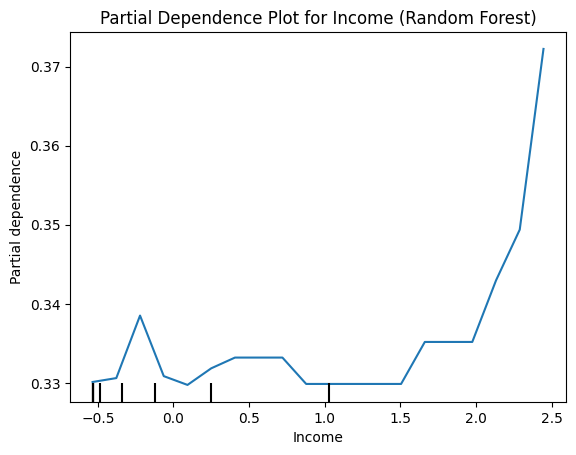

In [44]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select a feature of interest (e.g., 'Income')
feature_of_interest = 'Income'  # Replace with your feature

# Ensure the feature exists in the feature names
if feature_of_interest in feature_names:
    # Plot PDP
    PartialDependenceDisplay.from_estimator(
        rf_model,
        X_train,
        features=[feature_names.index(feature_of_interest)],  # Pass the feature index
        feature_names=feature_names,  # Pass the feature names
        grid_resolution=20
    )
    plt.title(f"Partial Dependence Plot for {feature_of_interest} (Random Forest)")
    plt.show()
else:
    print(f"Feature '{feature_of_interest}' not found in feature names.")

Permutation Importance

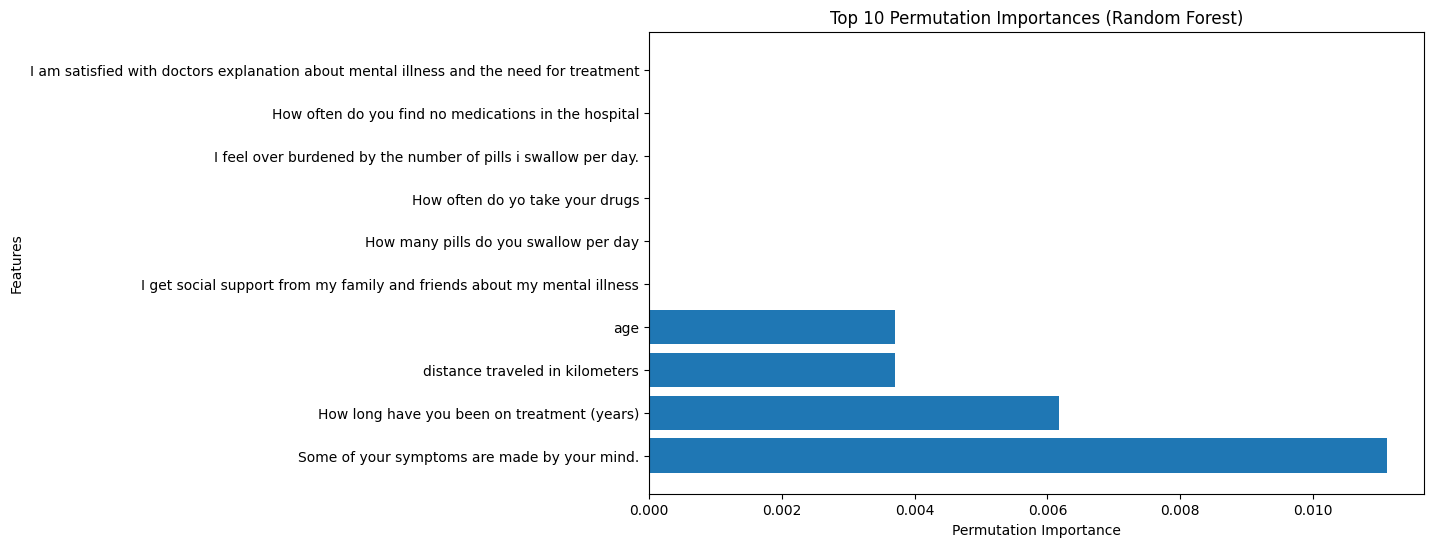

In [45]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=42)

# Sort features by importance
sorted_indices = result.importances_mean.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]  # Use original feature names
sorted_importances = result.importances_mean[sorted_indices]

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_importances[:10])  # Top 10 features
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Top 10 Permutation Importances (Random Forest)")
plt.show()

LIME (Local Interpretable Model-agnostic Explanations)

In [1]:
import lime
import lime.lime_tabular

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,  # Use original feature names
    class_names=['Non-Adherence', 'Adherence'],  # Replace with your target classes
    mode='classification'
)

# Explain a specific instance (e.g., the first instance in the test set)
instance = X_test[0]
exp = explainer.explain_instance(instance, rf_model.predict_proba, num_features=10)

# Display the explanation
exp.show_in_notebook()

NameError: name 'X_train' is not defined

##KNN

In [32]:
import joblib

# Replace with the path to your KNN model on Google Drive
model_path = '/content/Machine-Learning/models/knn_model.pkl'

# Load the model
knn_model = joblib.load(model_path)

Partial Dependence Plots (PDP)

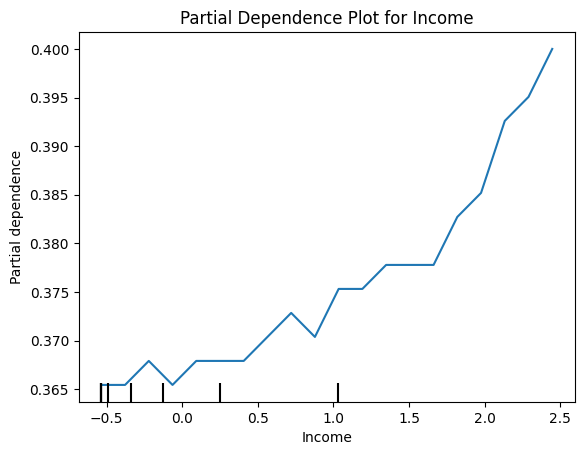

In [40]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select a feature of interest (e.g., 'Income')
feature_of_interest = 'Income'  # Replace with your feature

# Ensure the feature exists in the feature names
if feature_of_interest in feature_names:
    # Plot PDP
    PartialDependenceDisplay.from_estimator(
        knn_model,
        X_train,
        features=[feature_names.index(feature_of_interest)],  # Pass the feature index
        feature_names=feature_names,  # Pass the feature names
        grid_resolution=20
    )
    plt.title(f"Partial Dependence Plot for {feature_of_interest}")
    plt.show()
else:
    print(f"Feature '{feature_of_interest}' not found in feature names.")

Permutation Importance:

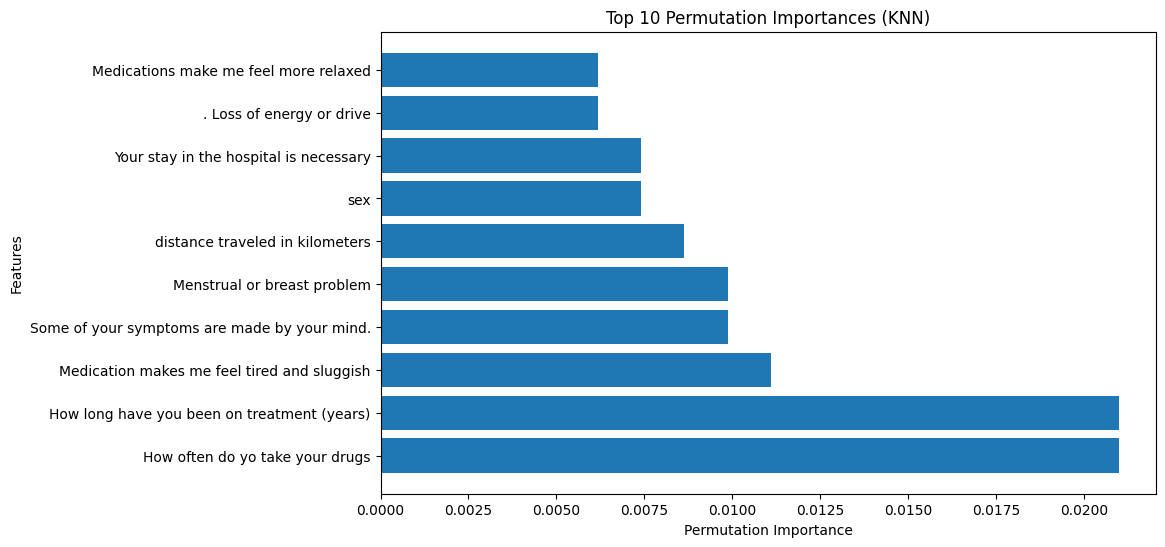

In [41]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(knn_model, X_train, y_train, n_repeats=10, random_state=42)

# Sort features by importance
sorted_indices = result.importances_mean.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]  # Use original feature names
sorted_importances = result.importances_mean[sorted_indices]

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_importances[:10])  # Top 10 features
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Top 10 Permutation Importances (KNN)")
plt.show()

 LIME:

In [42]:


import lime
import lime.lime_tabular

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,  # Use original feature names
    class_names=['Non-Adherence', 'Adherence'],  # Replace with your target classes
    mode='classification'
)

# Explain a specific instance (e.g., the first instance in the test set)
instance = X_test[0]
exp = explainer.explain_instance(instance, knn_model.predict_proba, num_features=10)

# Display the explanation
exp.show_in_notebook()